# ============================================
# Module 9b: Foundations of Training & Transformers
# Lab 2 – Training Loops and Loss Curves (Toy NLP)
# ============================================
**Author:** Dr. Dasha Trofimova

### Learning Goals
- Understand forward pass, backward pass, and optimizer updates
- Visualize loss and accuracy curves over epochs
- Interpret underfitting/overfitting on a simple NLP task

---


In [1]:
!pip install scikit-learn torch matplotlib seaborn --quiet

import numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid", context="talk")
torch.manual_seed(42); np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [2]:
# Tiny synthetic sentiment dataset
pos = ["i love this","great job","fantastic product","amazing quality","happy purchase",
       "wonderful experience","brilliant work","so good","excellent result","superb service"]
neg = ["i hate this","terrible job","awful product","poor quality","sad purchase",
       "horrible experience","bad work","so bad","disappointing result","worse service"]

X = pos*5 + neg*5
y = [1]* (len(pos)*5) + [0]*(len(neg)*5)
X, y = shuffle(X, y, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=200)
Xv = tfidf.fit_transform(X).astype(np.float32)

Xtr, Xte, ytr, yte = train_test_split(Xv, y, test_size=0.25, stratify=y, random_state=42)

Xtr_t = torch.tensor(Xtr.toarray()); Xte_t = torch.tensor(Xte.toarray())
ytr_t = torch.tensor(ytr, dtype=torch.long); yte_t = torch.tensor(yte, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xte_t, yte_t), batch_size=128)

Xtr_t.shape, Xte_t.shape

(torch.Size([75, 49]), torch.Size([25, 49]))

Epoch 01 | train_loss=0.693  val_loss=0.680  val_acc=0.520
Epoch 10 | train_loss=0.003  val_loss=0.001  val_acc=1.000
Epoch 20 | train_loss=0.000  val_loss=0.000  val_acc=1.000
Epoch 30 | train_loss=0.000  val_loss=0.000  val_acc=1.000
Epoch 40 | train_loss=0.000  val_loss=0.000  val_acc=1.000


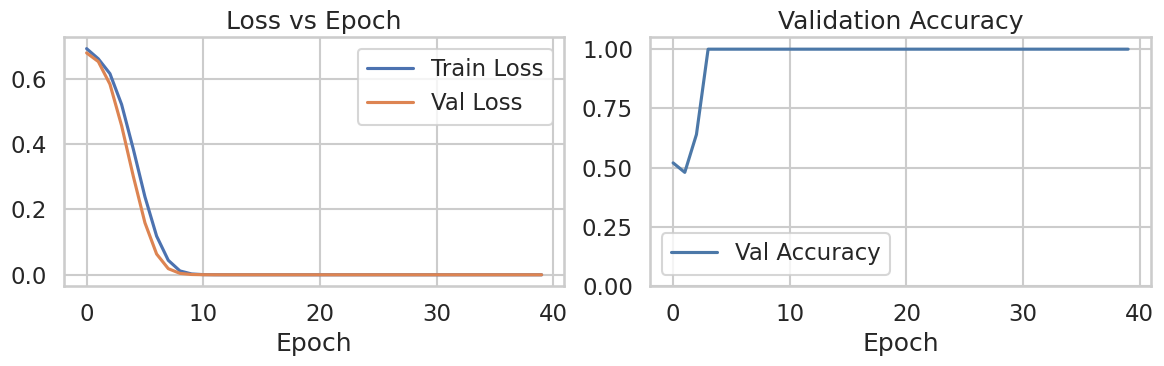

In [3]:
# Simple MLP classifier + training loop
class MLP(nn.Module):
    def __init__(self, in_dim, h=64, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, out_dim)
        )
    def forward(self, x): return self.net(x)

model = MLP(Xtr_t.shape[1]).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-2)
crit  = nn.CrossEntropyLoss()

epochs=40
train_loss, val_loss, val_acc = [], [], []

for ep in range(1, epochs+1):
    model.train(); ep_loss=0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = crit(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        ep_loss += loss.item()*len(xb)
    ep_loss /= len(train_loader.dataset)
    train_loss.append(ep_loss)

    model.eval(); vloss=0; correct=0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = crit(logits, yb)
            vloss += loss.item()*len(xb)
            pred = logits.argmax(1)
            correct += (pred==yb).sum().item()
    vloss /= len(val_loader.dataset)
    acc = correct/len(val_loader.dataset)
    val_loss.append(vloss); val_acc.append(acc)

    if ep in [1,10,20,30,40]:
        print(f"Epoch {ep:02d} | train_loss={ep_loss:.3f}  val_loss={vloss:.3f}  val_acc={acc:.3f}")

fig, axs = plt.subplots(1,2, figsize=(12,4))
axs[0].plot(train_loss, label="Train Loss"); axs[0].plot(val_loss, label="Val Loss")
axs[0].set_title("Loss vs Epoch"); axs[0].set_xlabel("Epoch"); axs[0].legend()
axs[1].plot(val_acc, label="Val Accuracy", color="#4C78A8")
axs[1].set_title("Validation Accuracy"); axs[1].set_xlabel("Epoch"); axs[1].set_ylim(0,1.05); axs[1].legend()
plt.tight_layout(); plt.show()

In [4]:
from google.colab import files
uploaded = files.upload()  # Select your image file manually


Saving general_vs_nns_linear-min.png to general_vs_nns_linear-min.png


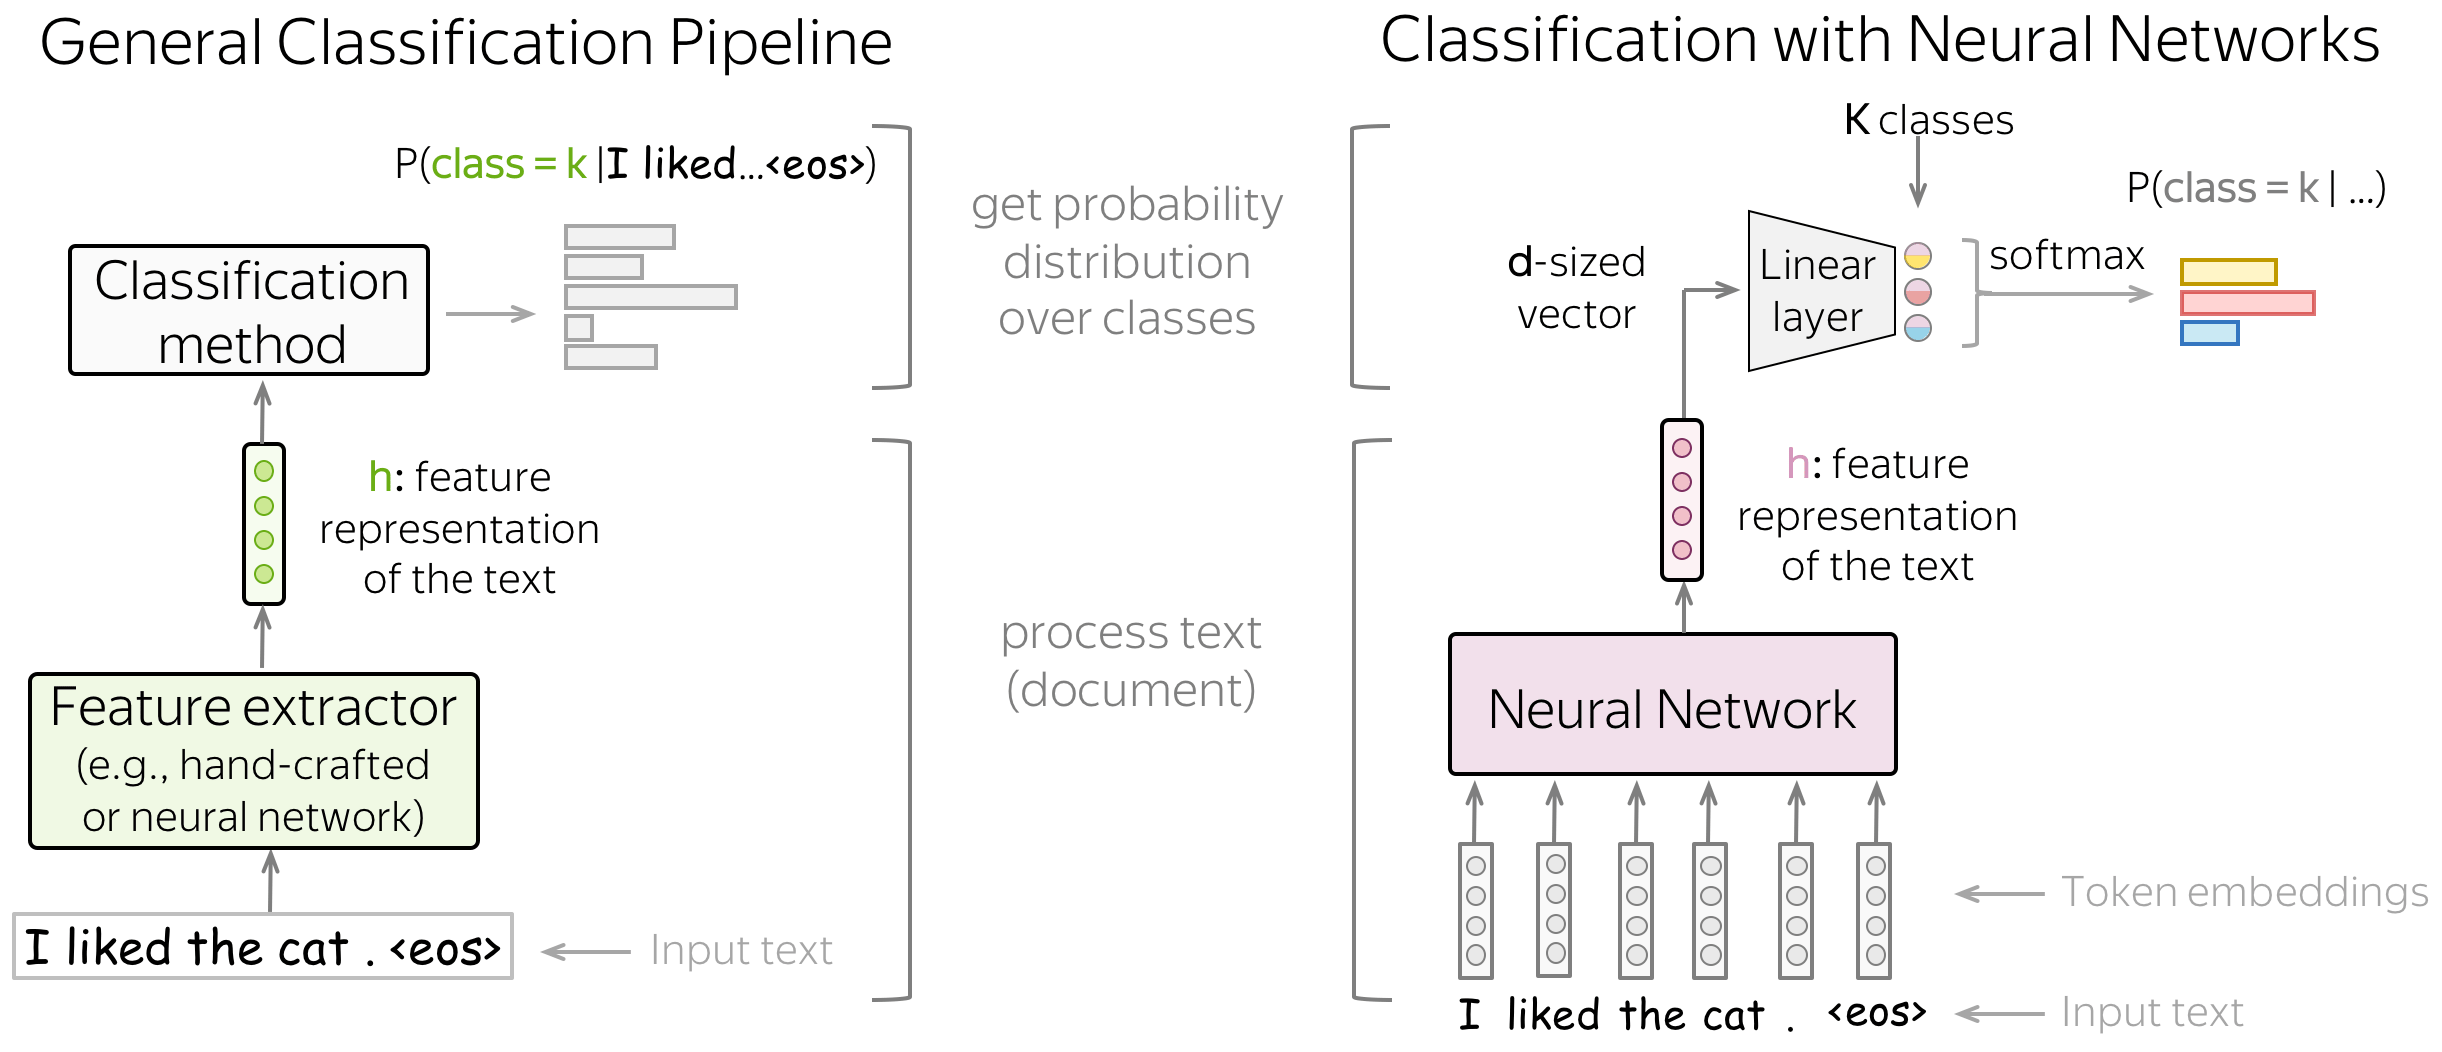

In [5]:
from IPython.display import Image, display

display(Image(filename="general_vs_nns_linear-min.png"))


### 🎯 Quick Card Quiz — Training Loop & Curves

**Color legend:**  
- **Blue = Train Loss/Train Phase**  
- **Orange = Validation Loss/Validation Phase**  
- **Green = Accuracy/Generalization**

1) If train loss keeps decreasing but validation loss starts increasing, what is happening?  
2) When do we call `model.eval()` and disable gradients?
3) Which curve best reflects generalization to unseen data?
